# 1. Set Up

In [1]:
import math
import os
import re
import sys
import time
import json
from pathlib import Path
import subprocess
import zipfile
from pydantic import BaseModel
from pydantic_core import from_json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import gmsh

sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import setup
import core
import custom_models as cm
import utils as ut
import plotting
import calculations as calc
import postprocess
    
import matplotlib
matplotlib.rc('figure', figsize=(7, 7))

In [2]:
#in MPa
def initialize_parameters(custom_mesh_filepath: str = None, soil_model: cm.PropertyTypeEnum = cm.PropertyTypeEnum.le, **kwargs) -> cm.AttrDict:
    params = cm.AttrDict()
    setattr(params, "custom_mesh_filepath", custom_mesh_filepath)
    setattr(params, "soil_model", soil_model)
    for key,value in kwargs.items():
        setattr(params, key, value)
    params.interface = False
    params.pile_manager = cm.PileManager(x=0, y=0, z=0, dx=0, dy=0, R=1, r=0.975,
                                         stickup_height = 10,
                                         embedded_depth = -10.5,
                                preferred_model= cm.PropertyTypeEnum.le,
                                props = {
                                    cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=200000, poisson_ratio=0.3),
                                },
                                interface = params.interface,
                                )

    soil_layer_1 = cm.SoilLayer(
        depth = -2,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=96, poisson_ratio=0.49),
            cm.PropertyTypeEnum.vM_Default_mfront: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.49, HardeningSlope = 1, YieldStress = 0.3),
            cm.PropertyTypeEnum.vM_Implicit_mfront: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.49, HardeningSlope = 1, YieldStress = 0.3),
            cm.PropertyTypeEnum.DP: cm.DruckerPragerProperties(youngs_modulus=96, poisson_ratio=0.35, phi=np.radians(15), c=1, v=np.radians(15)),
            cm.PropertyTypeEnum.DP_HYPER: cm.DPHYPERProps(youngs_modulus=96, poisson_ratio=0.35, phi=np.radians(15), c=1, v=np.radians(15), proximity = 0.5),
            cm.PropertyTypeEnum.MCC: cm.CamClayProperties(),
            }, 
            )
    soil_layer_2 = cm.SoilLayer(
        depth = -1.4,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=182.1, poisson_ratio=0.49),
            cm.PropertyTypeEnum.vM_Default_mfront: cm.VonMisesProperties(youngs_modulus=182.1, poisson_ratio=0.49, HardeningSlope = 1, YieldStress = 0.3),
            cm.PropertyTypeEnum.vM_Implicit_mfront: cm.VonMisesProperties(youngs_modulus=182.1, poisson_ratio=0.49, HardeningSlope = 1, YieldStress = 0.3),
            cm.PropertyTypeEnum.DP: cm.DruckerPragerProperties(youngs_modulus=182.1, poisson_ratio=0.35, phi=np.radians(15), c=1, v=np.radians(15)),
            cm.PropertyTypeEnum.DP_HYPER: cm.DPHYPERProps(youngs_modulus=182.1, poisson_ratio=0.35, phi=np.radians(15), c=1, v=np.radians(15), proximity = 0.5),
            cm.PropertyTypeEnum.MCC: cm.CamClayProperties(),
            }, 
            )
    soil_layer_3 = cm.SoilLayer(
        depth = -7.1,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=351.3, poisson_ratio=0.49),
            cm.PropertyTypeEnum.vM_Default_mfront: cm.VonMisesProperties(youngs_modulus=351.3, poisson_ratio=0.49, HardeningSlope = 1, YieldStress = 0.3),
            cm.PropertyTypeEnum.vM_Implicit_mfront: cm.VonMisesProperties(youngs_modulus=182.1, poisson_ratio=0.49, HardeningSlope = 1, YieldStress = 0.3),
            cm.PropertyTypeEnum.DP: cm.DruckerPragerProperties(youngs_modulus=351.3, poisson_ratio=0.35, phi=np.radians(15), c=1, v=np.radians(15)),
            cm.PropertyTypeEnum.DP_HYPER: cm.DPHYPERProps(youngs_modulus=351.3, poisson_ratio=0.35, phi=np.radians(15), c=1, v=np.radians(15), proximity = 0.5),
            cm.PropertyTypeEnum.MCC: cm.CamClayProperties(),
                 }, 
            )
    soil_layer_4 = cm.SoilLayer(
        depth = -29.5,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=668.4, poisson_ratio=0.49),
            cm.PropertyTypeEnum.vM_Default_mfront: cm.VonMisesProperties(youngs_modulus=668.4, poisson_ratio=0.49, HardeningSlope = 1, YieldStress = 0.3),
            cm.PropertyTypeEnum.vM_Implicit_mfront: cm.VonMisesProperties(youngs_modulus=668.4, poisson_ratio=0.49, HardeningSlope = 1, YieldStress = 0.3),
            cm.PropertyTypeEnum.DP: cm.DruckerPragerProperties(youngs_modulus=668.4, poisson_ratio=0.35, phi=np.radians(15), c=1, v=np.radians(15)),
            cm.PropertyTypeEnum.DP_HYPER: cm.DPHYPERProps(youngs_modulus=668.4, poisson_ratio=0.35, phi=np.radians(15), c=1, v=np.radians(15), proximity = 0.5),
            cm.PropertyTypeEnum.MCC: cm.CamClayProperties(),
            }, 
            )
    
    # params.interface_manager = cm.InterfaceManager(
    #     preferred_model = cm.PropertyTypeEnum.vM,
    #     props = {
    #         cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=96, poisson_ratio=0.49),
    #         cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.49,HardeningSlope = 5000, YieldStress = 20),
    #         cm.PropertyTypeEnum.DP: cm.DruckerPragerProperties(youngs_modulus=668.4, poisson_ratio=0.49, phi=np.radians(0.05), c=0, v=np.radians(0.05)),
    #         },
    #         )
    
    #=======================================================
    #=======================================================
    #=======================================================
    #if the soil domain is a cuboid
    params.box_manager = cm.BoxManager(x=-80, y=-80, z=0, dx=160, dy=80,
        layers=[
        soil_layer_1,
        soil_layer_2,
        soil_layer_3,
        soil_layer_4,   
        ],
        far_field_size=5,
        near_field_dist=5,
        near_field_size=0.05,
    )
    #if the soil domain is a half cylinder
    params.cylinder_manager = cm.CylinderManager(
        x=0, 
        y=0, 
        z=0, 
        dx=0, 
        dy=0, 
        r=80,
        pile_R = params.pile_manager.R,
        pile_r = params.pile_manager.r,
        layers=[
        soil_layer_1,
        soil_layer_2,
        soil_layer_3,
        soil_layer_4,   
        ],
        mesh_radial_progression = 1.3,
        mesh_radial_divisions = 10,
    )
    #=======================================================
    #=======================================================
    #=======================================================
    
    def custom_generate_physical_groups_mfront(params) -> list[cm.PhysicalGroup]:
        physical_group_list = [
            cm.PhysicalGroup(
                meshnet_id=1,
                name="MFRONT_MAT_1",
                preferred_model=params.cylinder_manager.layers[0].preferred_model,
                props=params.cylinder_manager.layers[0].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=2,
                name="MFRONT_MAT_2",
                preferred_model=params.cylinder_manager.layers[1].preferred_model,
                props=params.cylinder_manager.layers[1].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=3,
                name="MFRONT_MAT_3",
                preferred_model=params.cylinder_manager.layers[2].preferred_model,
                props=params.cylinder_manager.layers[2].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=4,
                name="MFRONT_MAT_4",
                preferred_model=params.cylinder_manager.layers[3].preferred_model,
                props=params.cylinder_manager.layers[3].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=5,
                name="MFRONT_MAT_5",
                preferred_model=params.pile_manager.preferred_model,
                props=params.pile_manager.props,
                ),
        ]
        return physical_group_list
    
    def custom_generate_physical_groups_mofem(params) -> list[cm.PhysicalGroup]:
        physical_group_list = []
        return physical_group_list
    
    
    if getattr(params, "custom_mesh_filepath", False):
        try:
            if params.use_mfront:
                params.custom_generate_physical_groups = custom_generate_physical_groups_mfront
            else:
                params.custom_generate_physical_groups = custom_generate_physical_groups_mofem
        except NameError as e:
            raise NameError("Must provided the custom callback 'custom_generate_physical_groups' to inject attributes to the main commmand.")
   
    params.nproc = 32 # number of processors/cores used
    params.dim = 3
    
    params.wk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test")
    params.read_med_exe = "/mofem_install/jupyter/thomas/um_view_release/bin/read_med"
    params.h5m_to_vtk_converter = "/mofem_install/jupyter/thomas/um_view_release/bin/convert.py"
    params.partition_exe = "/mofem_install/jupyter/thomas/um_view_release/bin/mofem_part"
    if params.use_mfront:
        params.exe = f"/mofem_install/jupyter/thomas/um_view/tutorials/adv-1/contact_3d"
    else:
        params.exe = f"/mofem_install/jupyter/thomas/um_view_release/adolc_plasticity/adolc_plasticity_3d"
    params.paraview_path = "/mofem_install/jupyter/thomas/ParaView-5.13.1-MPI-Linux-Python3.10-x86_64/bin/pvpython"
    params.ffmpeg_path = '/mofem_install/jupyter/thomas/ffmpeg-7.0.2-amd64-static/ffmpeg'
    params.preset_dir = '/mofem_install/jupyter/thomas/mfront_example_test/src/presets'
    
    return params

In [3]:
class InitParams(BaseModel):
    soil_model: cm.PropertyTypeEnum
    custom_mesh_filepath: str
    FEA_completed: bool = True
    days_since_epoch: int | None = None
    sim_otd: int | None = None
    base: str = "hex"

In [4]:
# # case_name = "pile_CL2"
# # case_name = "pile_CL2_sparse_slices"
# # case_name = "pile_CL2_circumference_unbiased"
# # case_name = "pile_CL2_low_vert_res_ref_31.5"
# # case_name = "pile_CL2_sparse_pile"
# # case_name = "pile_CM2"
# # case_name = "pile_CM9"
# case_name = "pile_CM3"

# order = 2
# if order == 1:
#     order_str = '1st'
# elif order == 2:
#     order_str = '2nd'
# bulk_sim_id = f"{case_name}_le_check_{order_str}_order"
# bulk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test/simulations/bulk_{bulk_sim_id}")
# bulk_dir.mkdir(parents=True, exist_ok=True)
# bulk_log = bulk_dir / "pile_bulk.json"
# recycle = False
# if recycle:
#     prior_bulk_analysis = json.load(open(bulk_log))
#     bulk_analysis_set = [
#         InitParams.model_validate(from_json(analysis)) for no, analysis in prior_bulk_analysis.items()
#     ]
# else:
#     bulk_analysis_set = [
#         InitParams(soil_model=cm.PropertyTypeEnum.le_adolc, custom_mesh_filepath=f"/mofem_install/jupyter/thomas/mfront_example_test/user_data/mesh/pile/{case_name}_le_adolc_10.cub", base="hex", FEA_completed=False, days_since_epoch=153, sim_otd=13),
#         InitParams(soil_model=cm.PropertyTypeEnum.le_adolc, custom_mesh_filepath=f"/mofem_install/jupyter/thomas/mfront_example_test/user_data/mesh/pile/{case_name}_le_adolc_9.cub", base="hex", FEA_completed=False, days_since_epoch=153, sim_otd=14),
#         InitParams(soil_model=cm.PropertyTypeEnum.le_adolc, custom_mesh_filepath=f"/mofem_install/jupyter/thomas/mfront_example_test/user_data/mesh/pile/{case_name}_le_adolc_8.cub", base="hex", FEA_completed=False, days_since_epoch=153, sim_otd=15),
#         InitParams(soil_model=cm.PropertyTypeEnum.le_adolc, custom_mesh_filepath=f"/mofem_install/jupyter/thomas/mfront_example_test/user_data/mesh/pile/{case_name}_le_adolc_7.cub", base="hex", FEA_completed=False, days_since_epoch=153, sim_otd=16),
#         InitParams(soil_model=cm.PropertyTypeEnum.le_adolc, custom_mesh_filepath=f"/mofem_install/jupyter/thomas/mfront_example_test/user_data/mesh/pile/{case_name}_le_adolc_6.cub", base="hex", FEA_completed=False, days_since_epoch=153, sim_otd=17),
#         InitParams(soil_model=cm.PropertyTypeEnum.le_adolc, custom_mesh_filepath=f"/mofem_install/jupyter/thomas/mfront_example_test/user_data/mesh/pile/{case_name}_le_adolc_5.cub", base="hex", FEA_completed=False, days_since_epoch=153, sim_otd=18),
#         InitParams(soil_model=cm.PropertyTypeEnum.le_adolc, custom_mesh_filepath=f"/mofem_install/jupyter/thomas/mfront_example_test/user_data/mesh/pile/{case_name}_le_adolc_4.cub", base="hex", FEA_completed=False, days_since_epoch=153, sim_otd=19),
#         InitParams(soil_model=cm.PropertyTypeEnum.le_adolc, custom_mesh_filepath=f"/mofem_install/jupyter/thomas/mfront_example_test/user_data/mesh/pile/{case_name}_le_adolc_3.cub", base="hex", FEA_completed=False, days_since_epoch=153, sim_otd=20),
#         InitParams(soil_model=cm.PropertyTypeEnum.le_adolc, custom_mesh_filepath=f"/mofem_install/jupyter/thomas/mfront_example_test/user_data/mesh/pile/{case_name}_le_adolc_2.cub", base="hex", FEA_completed=False, days_since_epoch=150, sim_otd=13),
#         InitParams(soil_model=cm.PropertyTypeEnum.le_adolc, custom_mesh_filepath=f"/mofem_install/jupyter/thomas/mfront_example_test/user_data/mesh/pile/{case_name}_le_adolc_1.cub", base="hex", FEA_completed=False, days_since_epoch=140, sim_otd=1),
#     ]
    
# if case_name.startswith("pile_CM2"):
#     outer_radius = 0.381
#     inner_radius = 0.371
#     stickup_height = 10
#     embeded_depth = -2.3
# elif case_name.startswith("pile_CM9"):
#     outer_radius = 0.381
#     inner_radius = 0.368
#     stickup_height = 10
#     embeded_depth = -4.0
# elif case_name.startswith("pile_CM3"):
#     outer_radius = 0.381
#     inner_radius = 0.356
#     stickup_height = 10
#     embeded_depth = -7.6

# elif case_name.startswith("pile_CL2"):
#     outer_radius = 1
#     inner_radius = 0.975
#     stickup_height = 10
#     embeded_depth = -10.5
# else:
#     raise ValueError("Case name not recognized")
# points_of_interest = [
#     cm.Point(x=outer_radius,y=0,z=stickup_height),
#     cm.Point(x=outer_radius,y=0,z=0),
#     cm.Point(x=-outer_radius,y=0,z=0),
# ]
# line = cm.Line(
#     pt1 = cm.Point(x=-(outer_radius+inner_radius)/2,y=0,z=0),
#     pt2 = cm.Point(x=-(outer_radius+inner_radius)/2,y=0,z=embeded_depth),
# )

In [5]:
# case_name = "pile_CL2"
# case_name = "pile_CM2"
# case_name = "pile_CM9"
case_name = "pile_CM3"

order = 2
if order == 1:
    order_str = '1st'
elif order == 2:
    order_str = '2nd'
bulk_sim_id = f"{case_name}_plasticity_{order_str}_order_7"
bulk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test/simulations/bulk_{bulk_sim_id}")
bulk_dir.mkdir(parents=True, exist_ok=True)
bulk_log = bulk_dir / "pile_bulk.json"
recycle = False
if recycle:
    prior_bulk_analysis = json.load(open(bulk_log))
    bulk_analysis_set = [
        InitParams.model_validate(from_json(analysis)) for no, analysis in prior_bulk_analysis.items()
    ]
else:
    bulk_analysis_set = [
        # InitParams(soil_model=cm.PropertyTypeEnum.vM_adolc, custom_mesh_filepath=f"/mofem_install/jupyter/thomas/mfront_example_test/user_data/mesh/pile/{case_name}_vM_adolc_H_7.cub", base="hex", FEA_completed=False, days_since_epoch=153, sim_otd=13),
        # InitParams(soil_model=cm.PropertyTypeEnum.vM_adolc, custom_mesh_filepath=f"/mofem_install/jupyter/thomas/mfront_example_test/user_data/mesh/pile/{case_name}_body_force_vM_adolc_su_7.cub", base="hex", FEA_completed=False, days_since_epoch=153, sim_otd=13),
        InitParams(soil_model=cm.PropertyTypeEnum.vM_adolc, custom_mesh_filepath=f"/mofem_install/jupyter/thomas/mfront_example_test/user_data/mesh/pile/{case_name}_vM_adolc_su_7.cub", base="hex", FEA_completed=False, days_since_epoch=153, sim_otd=14),
        InitParams(soil_model=cm.PropertyTypeEnum.vM_adolc, custom_mesh_filepath=f"/mofem_install/jupyter/thomas/mfront_example_test/user_data/mesh/pile/{case_name}_vM_adolc_su_8.cub", base="hex", FEA_completed=False, days_since_epoch=153, sim_otd=14),
        InitParams(soil_model=cm.PropertyTypeEnum.vM_adolc, custom_mesh_filepath=f"/mofem_install/jupyter/thomas/mfront_example_test/user_data/mesh/pile/{case_name}_vM_adolc_H_7.cub", base="hex", FEA_completed=False, days_since_epoch=153, sim_otd=14),
    ]
    
if case_name.startswith("pile_CM2"):
    outer_radius = 0.381
    inner_radius = 0.371
    stickup_height = 10
    embeded_depth = -2.3
elif case_name.startswith("pile_CM9"):
    outer_radius = 0.381
    inner_radius = 0.368
    stickup_height = 10
    embeded_depth = -4.0
elif case_name.startswith("pile_CM3"):
    outer_radius = 0.381
    inner_radius = 0.356
    stickup_height = 10
    embeded_depth = -7.6

elif case_name.startswith("pile_CL2"):
    outer_radius = 1
    inner_radius = 0.975
    stickup_height = 10
    embeded_depth = -10.5
else:
    raise ValueError("Case name not recognized")
points_of_interest = [
    cm.Point(x=outer_radius,y=0,z=stickup_height),
    cm.Point(x=outer_radius,y=0,z=0),
    cm.Point(x=-outer_radius,y=0,z=0),
]
line = cm.Line(
    pt1 = cm.Point(x=-(outer_radius+inner_radius)/2,y=0,z=0),
    pt2 = cm.Point(x=-(outer_radius+inner_radius)/2,y=0,z=embeded_depth),
)

# case_name = "pile_CL2"
# order = 2
# if order == 1:
#     order_str = '1st'
# elif order == 2:
#     order_str = '2nd'
# bulk_sim_id = f"{case_name}_plasticity_{order_str}_order_7"
# bulk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test/simulations/bulk_{bulk_sim_id}")
# bulk_dir.mkdir(parents=True, exist_ok=True)
# bulk_log = bulk_dir / "pile_bulk.json"
# recycle = True
# if recycle:
#     prior_bulk_analysis = json.load(open(bulk_log))
#     bulk_analysis_set = [
#         InitParams.model_validate(from_json(analysis)) for no, analysis in prior_bulk_analysis.items()
#     ]
# else:
#     bulk_analysis_set = [
#         InitParams(soil_model=cm.PropertyTypeEnum.vM_adolc, custom_mesh_filepath=f"/mofem_install/jupyter/thomas/mfront_example_test/user_data/mesh/pile/{case_name}_vM_adolc_su_7.cub", base="hex", FEA_completed=False, days_since_epoch=140, sim_otd=2),
#         InitParams(soil_model=cm.PropertyTypeEnum.vM_adolc, custom_mesh_filepath=f"/mofem_install/jupyter/thomas/mfront_example_test/user_data/mesh/pile/{case_name}_vM_adolc_H_7.cub", base="hex", FEA_completed=False, days_since_epoch=140, sim_otd=1),
#         # InitParams(soil_model=cm.PropertyTypeEnum.DP_adolc, custom_mesh_filepath=f"/mofem_install/jupyter/thomas/mfront_example_test/user_data/mesh/pile/{case_name}_DP_adolc_3.cub", base="hex", FEA_completed=False, days_since_epoch=140, sim_otd=2),
#     ]
    
# if case_name.startswith("pile_CM2"):
#     points_of_interest = [
#         cm.Point(x=0.381,y=0,z=10),
#         cm.Point(x=0.381,y=0,z=0),
#         cm.Point(x=-0.381,y=0,z=0),
#     ]  
#     point = cm.Point(x=-.381,y=0,z=0)
#     point_top = cm.Point(x=.381,y=0,z=10)
# elif case_name.startswith("pile_CL2"):
#     points_of_interest = [
#         cm.Point(x=1,y=0,z=10),
#         cm.Point(x=1,y=0,z=0),
#         cm.Point(x=-1,y=0,z=0),
#     ]
#     point = cm.Point(x=-1,y=0,z=0)
#     point_top = cm.Point(x=1,y=0,z=10)
    
# else:
#     raise ValueError("Case name not recognized")

In [6]:
if not recycle:
    with open(bulk_log, 'w'): pass
parameters = {}
for i, init_params in enumerate(bulk_analysis_set):
    params = initialize_parameters(
        **init_params.dict(),
        order = order, #order of approximation functions
        case_name = case_name,
        points_of_interest = points_of_interest,
        use_mfront = False,
        final_time = 1, # [s]
        time_step = 1 / 100, # [s]
        options_file = "/mofem_install/jupyter/thomas/mfront_example_test/param_file.petsc",
        b_bar = 0,
        save_gauss = 0,
        convert_gauss = 0,
        # time_history = cm.TimeHistory(history = {
        #     0: 0, 
        #     0.5: 0, 
        #     1: 1,
        #     }
        # ),
        # body_time_history = cm.TimeHistory(history = {
        #     0: 0, 
        #     0.01: 1, 
        #     1: 1,
        #     }
        # ),
        # prescribed_force = cm.ForceBoundaryCondition(fx=0,fy=0,fz=0),
        prescribed_disp = cm.SurfaceBoundaryCondition(disp_ux=1, disp_uy=0 ,disp_uz=0),
        
        
        # line_of_interest = cm.Line(pt1=cm.Point(x=-1,y=0,z=10), pt2=cm.Point(x=-1,y=0,z=-40),),
        
        prescribed_BC_name = "FIX_X_1",
    )
    # 2. Simulation Parameters
    params = setup.setup(params) # 3. Log paths and meta
    if params.FEA_completed:
        # core.generate_mesh(params) # 4. Generate the mesh
        # core.mofem_compute(params) # 5. Running the analysis and export to .vtk file format
        # core.export_to_vtk(params)
        # postprocess.zip_vtks(params)
        # postprocess.extract_log(params)
        # postprocess.snes_csv(params)
        # postprocess.extract(params)
        # if "CM2" in params.case_name:
        #     postprocess.line_to_csv(params, cm.Line(pt1=cm.Point(x=-0.376,y=0,z=0), pt2=cm.Point(x=-0.376,y=0,z=-2.3)))
        # elif "CL2" in params.case_name:
        #     postprocess.line_to_csv(params, cm.Line(pt1=cm.Point(x=-0.9875,y=0,z=0), pt2=cm.Point(x=-0.9875,y=0,z=-10.5)))
        # postprocess.calculate(params)
        # postprocess.plot(params)
        pass
    else:
        core.generate_mesh(params) # 4. Generate the mesh
        core.mofem_compute(params) # 5. Running the analysis and export to .vtk file format
        core.export_to_vtk(params)
        postprocess.zip_vtks(params)
        postprocess.extract_log(params)
        postprocess.snes_csv(params)
        postprocess.extract(params)
        postprocess.line_to_csv(params, line)
        postprocess.calculate(params)
        postprocess.plot(params)
        
    props = cm.BulkAnalysisProps(
        data_dir = params.data_dir,
        mesh_name_appended = params.mesh_name_appended,
        total_force_log_file = params.total_force_log_file,
        PRESCRIBED_BC_force_log_file = params.PRESCRIBED_BC_force_log_file,
        DOFs_log_file =  params.DOFs_log_file,
        TOTAL_STRAIN_ENERGY_log_file =  params.TOTAL_STRAIN_ENERGY_log_file,
        ux_log_file= params.ux_log_file,
        full_fe_log = params.log_file,
        custom_mesh_filepath = params.custom_mesh_filepath,
        FEA_completed = params.FEA_completed,
        base = params.base,
        soil_model = params.soil_model,
        days_since_epoch = params.days_since_epoch,
        sim_otd = params.sim_otd,

    )
    parameters[f"{i}"] = props.model_dump_json(indent=2)
    

        
with open(bulk_log, 'w') as f:
    json.dump(parameters, f, indent=2)

╭──────────────────────────────╮
│  Simulation #1 for the day.  │
╰──────────────────────────────╯
╭─────────────────────────────────────╮
│  PARTITIONING MESH with mofem_part  │
╰─────────────────────────────────────╯
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 6fb3639729432643de602ddad2923eec86643d75
[0] <inform> Local time: 2025-1-19 5:6:34
[0] <inform> UTC time: 2025-1-19 5:6:34
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675317650 type BLOCKSET UNKNOWNNAME msId 1 name ADOLCMAT_0 block header:  blockCol = 0 blockMat = 0 blockDimension = 3
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675317651 type BLOCKSET UNKNOWNNAME msId 2 name ADOLCMAT_1 block header:  blockCol = 0 blockMat = 0 blockDimension = 3
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675317652 type BLOCKSET UNKNOWNNAME msId 3 name ADOLCMAT_2 block header:  blockCol = 0 blockMat = 0 blockDi

<Figure size 700x700 with 0 Axes>

1
1


TypeError: '>' not supported between instances of 'NoneType' and 'float'

<Figure size 700x700 with 0 Axes>

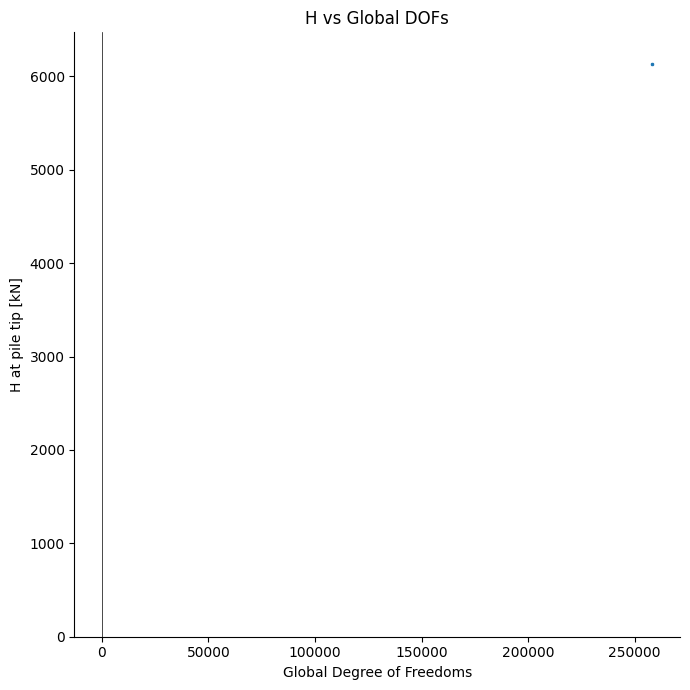

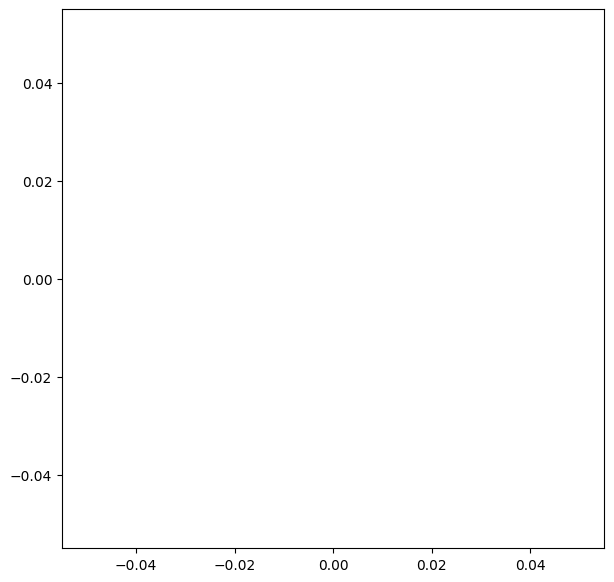

In [7]:
from pathlib import Path
import os
import json
import sys

import pydantic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import custom_models as cm
import plotting

bulk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test/simulations/bulk_{bulk_sim_id}")
bulk_log = bulk_dir / "pile_bulk.json"

if os.path.exists(bulk_log):
    with open(bulk_log, 'r') as f:
        logs = json.load(f)
else:
    raise FileNotFoundError(f"The bulk log with the id '{bulk_sim_id}'is not found. Possibly because this bulk analysis was not performed yet?")

bulk_graph_dir = bulk_dir / "graphs"
bulk_graph_dir.mkdir(parents=True, exist_ok=True)
bulk_csv = bulk_dir / "pile_bulk.csv"


df = {
    "DOFs": [],
    "ground_level_final_disp": [],
    "ground_level_final_disp_relative_error": [],
    "pile_top_final_disp": [],
    "pile_top_final_disp_relative_error": [],
    "H": [],
    "H_relative_error": [],
    "total_strain_energy": [],
    "total_strain_energy_relative_error": [],
    "compute_cpu_time": [],
    "compute_wall_time": [],
    "compute_cpu_time_relative_error": [],
    "compute_wall_time_relative_error": [],
}

previous_values = {
    "ground_level_final_disp": None,
    "pile_top_final_disp": None,
    "H": None,
    "total_strain_energy": None,
    "compute_cpu_time": None,
    "compute_wall_time": None,
}

for i, log in list(logs.items()):
    params = cm.BulkAnalysisProps.parse_raw(log)
    csv_files = [points_of_interest[0].point_dir(params)/f for f in os.listdir(points_of_interest[0].point_dir(params)) if f.startswith("point_data_") and f.endswith(".csv")]
    csv_files.extend([points_of_interest[2].point_dir(params)/f for f in os.listdir(points_of_interest[2].point_dir(params)) if f.startswith("point_data_") and f.endswith(".csv")])
    max_sig_eq = 1e20
    for csv_file in csv_files:
        # pid = int(csv_file.split('_')[2].split('.')[0])
        csv = pd.read_csv(csv_file)
        if cm.Point(x=csv["x"].max(),y=csv["y"].max(),z=csv["z"].max()) == points_of_interest[2]:
            data_poi_mudline = csv
        if cm.Point(x=csv["x"].max(),y=csv["y"].max(),z=csv["z"].max()) == points_of_interest[0]:
            data_poi_top = csv
        # if f"final_stress_{pid}" not in list(df.keys()):
    #         df[f"final_stress_{pid}"] = []
    #         df[f"final_strain_{pid}"] = []
    #     else:
    #         df[f"final_stress_{pid}"].append(csv["STRESS_magnitude"].iloc[-1])
    #         df[f"final_strain_{pid}"].append(csv["STRAIN_magnitude"].iloc[-1])
            
    data_tot_force=pd.read_csv(params.total_force_log_file,sep='\s+',header=None)
    data_bc_force=pd.read_csv(params.PRESCRIBED_BC_force_log_file,sep='\s+',header=None, skiprows=1)
    data_dofs=pd.read_csv(params.DOFs_log_file,sep='\s+',header=None)
    data_TOTAL_STRAIN_ENERGY=pd.read_csv(params.TOTAL_STRAIN_ENERGY_log_file,sep='\s+',header=None)
    
    # Function to extract time from a line in the log file
    def extract_time(pattern, log_file):
        result = subprocess.run(
            f"grep '^{pattern}' {log_file} | awk '{{print $2}}'",
            shell=True, text=True, capture_output=True
        )
        time_str = result.stdout.strip()
        if not time_str:
            raise ValueError(f"Failed to find '{pattern}' in the log file.")
        
        # Convert 'XmY.Zs' format to seconds
        match = re.match(r"(\d+)m([\d.]+)s", time_str)
        if match:
            minutes = int(match.group(1))
            seconds = float(match.group(2))
            return minutes * 60 + seconds
        else:
            raise ValueError(f"Unexpected time format: '{time_str}'")

    # Extract times
    real_time = extract_time("real", params.full_fe_log)
    user_time = extract_time("user", params.full_fe_log)
    sys_time = extract_time("sys", params.full_fe_log)

    # Calculate total CPU time and wall-clock time
    user_sys_time = user_time + sys_time
    total_cpu_time = user_sys_time
    wall_clock_time = real_time
    
    
    pile_tip_lateral_load = - data_bc_force[4].values * 2 * (10 ** 6) / 1000
    ground_level_passive_lateral_final_disp = data_poi_mudline["DISPLACEMENT_0"].iloc[-1]
    top_final_disp = data_poi_top["DISPLACEMENT_0"].iloc[-1]
    DOF = data_dofs[15][0]
    total_strain_energy = float(data_TOTAL_STRAIN_ENERGY[0][0])
    current_values = {
        "ground_level_final_disp": ground_level_passive_lateral_final_disp,
        "pile_top_final_disp": top_final_disp,
        "H": pile_tip_lateral_load[-1],
        "total_strain_energy": total_strain_energy,
        "compute_cpu_time": total_cpu_time,
        "compute_wall_time": wall_clock_time,
    }
    
    for key in current_values:
        if previous_values[key] is not None:
            relative_error = abs(current_values[key] - previous_values[key]) / abs(previous_values[key]) * 100
            df[f"{key}_relative_error"].append(relative_error)
        else:
            df[f"{key}_relative_error"].append(None)  # No previous value to compare with
        previous_values[key] = current_values[key]
    
    
    df["DOFs"].append(DOF)
    df["H"].append(pile_tip_lateral_load[-1])
    df["ground_level_final_disp"].append(ground_level_passive_lateral_final_disp)
    df["pile_top_final_disp"].append(top_final_disp)
    df["total_strain_energy"].append(total_strain_energy)
    df["compute_cpu_time"].append(total_cpu_time)
    df["compute_wall_time"].append(wall_clock_time)

# for i, j in df.items():
#     print(i, len(j))

df["dDOFs"] = np.concatenate(([1], np.diff(df["DOFs"])))
print(len(df["DOFs"]))
print(len(df["dDOFs"]))
df = pd.DataFrame(df)

df.to_csv(bulk_csv)

plotting.plot_x_ys(df["DOFs"], [df["H"]], labels=[""], x_label='Global Degree of Freedoms', y_label='H at pile tip [kN]', title='H vs Global DOFs', save_as = f"{bulk_graph_dir}/001_H_DOFs.png", show=True, enforce_pass_through_zero=True)
plotting.plot_x_ys(df["DOFs"], [df["H_relative_error"]], labels=[""], colors=["r"], x_label='Global Degree of Freedoms', y_label='Relative Error of H at pile tip [-]', title='H Rel. Error vs Global DOFs', save_as = f"{bulk_graph_dir}/001_1_H_DOFs_rel_error.png", show=True, enforce_pass_through_zero=False, large_markers=True,x_log_scale=True)

plotting.plot_x_ys(df["DOFs"], [df["ground_level_final_disp"]], labels=["Displacement at Pile Tip [m]"], colors=None,x_label='Global Degree of Freedoms', y_label='Displacement at mudline [m]', title='Displacement vs Global DOFs', save_as = f"{bulk_graph_dir}/005_Displacement_ground_DOFs.png", show=True, enforce_pass_through_zero=True)
plotting.plot_x_ys(df["DOFs"], [df["ground_level_final_disp_relative_error"]], labels=["Relative error [%]"], colors=["r"],x_label='Global Degree of Freedoms', y_label='Relative Error of Displacement at mudline [-]', title='Displacement Rel. Eror vs Global DOFs', save_as = f"{bulk_graph_dir}/005_1_Displacement_ground_DOFs_rel_error.png", show=True, enforce_pass_through_zero=False,annotate_last_datapoint=True, large_markers=True,x_log_scale=True)

plotting.plot_x_ys(df["DOFs"], 
    [df["total_strain_energy"]], labels=["Total Strain Energy [-]"], colors=None, x_label='Global Degree of Freedoms', y_label='Total Strain Energy [-]', title='Total Strain Energy vs Global DOFs', save_as = f"{bulk_graph_dir}/008_total_strain_energy_DOFs.png", show=True, enforce_pass_through_zero=True,annotate_all_datapoints=True)
plotting.plot_x_ys(df["DOFs"], 
    [df["total_strain_energy_relative_error"]], labels=["Relative error [%]"], colors=["r"],x_label='Global Degree of Freedoms', y_label='Relative Error of Total Strain Energy [-]', title='Total Strain Energy Rel. Eror vs Global DOFs', save_as = f"{bulk_graph_dir}/008_1_total_strain_energy_DOFs_rel_error.png", show=True, enforce_pass_through_zero=False,annotate_all_datapoints=True, large_markers=True,x_log_scale=True)

plotting.plot_x_ys(df["DOFs"], [df["compute_cpu_time"]], labels=[""], x_label='Global Degree of Freedoms', y_label='CPU Time [s]', title='CPU Time vs Global DOFs', save_as = f"{bulk_graph_dir}/006_CPUTime_DOFs.png", show=True, enforce_pass_through_zero=True)
plotting.plot_x_ys(df["DOFs"], [df["compute_wall_time"]], labels=[""], x_label='Global Degree of Freedoms', y_label='Wall Time [s]', title='Wall Time vs Global DOFs', save_as = f"{bulk_graph_dir}/007_WallTime_DOFs.png", show=True, enforce_pass_through_zero=True)